# Bayesian Neural Network

If you are using Colab make sure your runtime is set to GPU and then proceed with running the cells in this notebook.

Comment the next 2 cells if you are using a local system. This is only if you are running this on Colab.

In [4]:
!git clone https://github.com/nerdimite/simple-bayesian-neural-net

In [ ]:
cd simple-bayesian-neural-net

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm.notebook import tqdm

In [3]:
# Importing Pyro and its modules
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

## Data and Neural Net

In [9]:
# Get the MNIST dataset
train_data = datasets.MNIST('mnist', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST('mnist', train=False, transform=transforms.ToTensor())

# Build the dataloaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(train_data, batch_size=128, shuffle=False)

In [13]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [14]:
class NeuralNet(nn.Module):
    '''Base Neural Network for Classification'''
    
    def __init__(self, in_dim=784, hidden_dim=1024, out_dim=10):
        super(NeuralNet, self).__init__()
        
        self.input = nn.Linear(in_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x):
        '''Returns the prediction logits'''        
        # Pass through the layers
        x = F.relu(self.input(x))
        out = self.output(x)
        
        return out

In [15]:
net = NeuralNet().to(device)

## Model

In [21]:
log_softmax = nn.LogSoftmax(dim=1)

In [22]:
def model(x_data, y_data):
    '''The Stochastic Model of the Neural Net'''
    
    # Defining the priors of the parameters
    inp_w_prior = Normal(loc=torch.zeros_like(net.input.weight).to(device), scale=torch.ones_like(net.input.weight).to(device))
    inp_b_prior = Normal(loc=torch.zeros_like(net.input.bias).to(device), scale=torch.ones_like(net.input.bias).to(device))

    out_w_prior = Normal(loc=torch.zeros_like(net.output.weight).to(device), scale=torch.ones_like(net.output.weight).to(device))
    out_b_prior = Normal(loc=torch.zeros_like(net.output.bias).to(device), scale=torch.ones_like(net.output.bias).to(device))
    
    priors = {'input.weight': inp_w_prior, 'input.bias': inp_b_prior,
              'output.weight': out_w_prior, 'output.bias': out_b_prior}
    
    # Convert the model params to random variables
    rnd_module = pyro.random_module("module", net, priors)
    # Sample a model
    sampled_model = rnd_module()
    
    # Make prediction
    y_hat = log_softmax(sampled_model(x_data))
    
    # Sample the observation
    pyro.sample("obs", Categorical(logits=y_hat), obs=y_data)

## Guide

In [23]:
softplus = nn.Softplus()

In [24]:
def guide(x_data, y_data):
    '''The Guide that is optimized using SVI'''
    
    # Input layer weight priors
    inp_w_mu = pyro.param('inp_w_mu', torch.randn_like(net.input.weight).to(device))
    inp_w_sigma = softplus(pyro.param('inp_w_sigma', torch.randn_like(net.input.weight).to(device)))
    inp_w_prior = Normal(loc=inp_w_mu, scale=inp_w_sigma)
    
    # Input layer bias priors
    inp_b_mu = pyro.param('inp_b_mu', torch.randn_like(net.input.bias).to(device))
    inp_b_sigma = softplus(pyro.param('inp_b_sigma', torch.randn_like(net.input.bias).to(device)))
    inp_b_prior = Normal(loc=inp_b_mu, scale=inp_b_sigma)
    
    # Output layer weight priors
    out_w_mu = pyro.param('out_w_mu', torch.randn_like(net.output.weight).to(device))
    out_w_sigma = softplus(pyro.param('out_w_sigma', torch.randn_like(net.output.weight).to(device)))
    out_w_prior = Normal(loc=out_w_mu, scale=out_w_sigma)
    
    # Output layer bias priors
    out_b_mu = pyro.param('out_b_mu', torch.randn_like(net.output.bias).to(device))
    out_b_sigma = softplus(pyro.param('out_b_sigma', torch.randn_like(net.output.bias).to(device)))
    out_b_prior = Normal(loc=out_b_mu, scale=out_b_sigma)
    
    # Priors
    priors = {'input.weight': inp_w_prior, 'input.bias': inp_b_prior,
              'output.weight': out_w_prior, 'output.bias': out_b_prior}
    
    # Convert the model params to random variables
    rnd_module = pyro.random_module("module", net, priors)
    
    return rnd_module().to(device)

## SVI

In [25]:
# Create a pyro optimizer
optimizer = Adam({"lr": 0.001})
# Create the SVI object with the ELBO loss
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

## Training

In [26]:
%%time
num_epochs = 20

for e in range(num_epochs):
    losses = []
    pbar = tqdm(desc=f"Epoch {e}", total=len(train_loader))
    
    for idx, (x_data, y_data) in enumerate(train_loader):
        x = x_data.view(-1,28*28).to(device)
        y = y_data.to(device)
        
        # Take an SVI step and get the loss
        loss = svi.step(x, y)
        losses.append(loss)
        
        
        pbar.update(1)
        pbar.set_postfix({'Loss': loss})
    
    pbar.set_postfix({'Mean Loss': sum(losses) / len(losses)})



Wall time: 3min 46s


In [28]:
# Saving the guide parameters
pyro.get_param_store().save('mnist.params')

## Prediction

In [29]:
def load_images(folder):
    '''Reads images from a folder and Returns a 4D tensor of images'''
    totensor = transforms.ToTensor()
    img_names = os.listdir(folder)
    img_names.sort(key=lambda x: int(x.split('.')[0]))

    images = []
    for img_name in img_names:
        image = Image.open(os.path.join(folder, img_name))
        image_tensor = totensor(image)
        images.append(image_tensor)
    
    return torch.stack(images)

In [30]:
# Load some test images
test_images = load_images('test_images')
test_images.shape

torch.Size([15, 1, 28, 28])

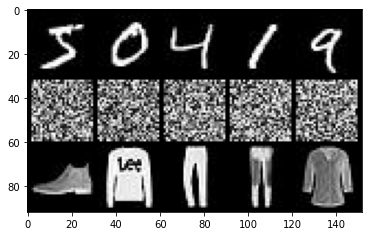

In [32]:
# Display the test images
grid = torchvision.utils.make_grid(test_images, nrow=5)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0))

In [33]:
def force_predict(x, num_samples=100):
    '''Make Forced Predictions while not accounting for uncertainity'''
    
    # Sample and Make prediction
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    y_hats = [model(x) for model in sampled_models]
    probs = F.softmax(torch.stack(y_hats), dim=2)
    
    # Calculate the mean prob
    mean_probs = torch.mean(probs, 0).detach().cpu().numpy()
    
    # Get class index and its probability
    class_idx = mean_probs.argmax(1)
    class_probs = mean_probs.max(1)
    
    return class_idx, class_probs

In [34]:
# Making forced predictions
fpred, fprobs = force_predict(test_images.view(-1, 28*28).cuda())
np.vstack((fpred, fprobs)).T

array([[5.        , 0.51213545],
       [0.        , 0.98999995],
       [4.        , 0.67956394],
       [1.        , 0.86990219],
       [9.        , 0.78110623],
       [2.        , 0.27014023],
       [2.        , 0.38802999],
       [5.        , 0.19964275],
       [2.        , 0.22082146],
       [5.        , 0.22641197],
       [2.        , 0.83138043],
       [2.        , 0.34996906],
       [8.        , 0.19806057],
       [2.        , 0.33631378],
       [2.        , 0.22069052]])

In [37]:
def predict(x, num_samples=100):
    '''Returns the predictions while allowing the model to refuse to predict'''
    
    # Get probabilities
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    y_hats = [model(x) for model in sampled_models]
    probs = F.softmax(torch.stack(y_hats), dim=2).detach().cpu().numpy()
    
    # Handling Uncertainity
    predictions = []
    for i in range(x.shape[0]):
        # Calculate median
        median = np.median(probs[:, i], 0)
        
        class_idx = median.argmax()
        class_prob = median.max()
        
        if class_prob > 0.2:
            predictions.append((class_idx, class_prob))
        else:
            predictions.append((-1, 0))
    
    return np.array(predictions)

In [38]:
# Making predictions while accounting for uncertainity
uc_preds = predict(test_images.view(-1, 28*28).cuda())
uc_preds

array([[ 5.,  1.],
       [ 0.,  1.],
       [ 4.,  1.],
       [ 1.,  1.],
       [ 9.,  1.],
       [-1.,  0.],
       [-1.,  0.],
       [-1.,  0.],
       [-1.,  0.],
       [-1.,  0.],
       [ 2.,  1.],
       [-1.,  0.],
       [-1.,  0.],
       [-1.,  0.],
       [-1.,  0.]])

### Evaluation

In [39]:
def forced_evaluate(test_loader):
    '''General Evaluation on the Test Set (forced prediction)'''
    num_correct = []
    
    for idx, (images, labels) in tqdm(enumerate(test_loader)):
        # Get inputs
        images, labels = images.view(-1,28*28).to(device), labels.numpy()
        # Make prediction
        preds, _ = force_predict(images)
        # Check num correct
        num_correct.extend((preds == labels).tolist())
    
    acc = np.array(num_correct).mean()
    print('Accuracy:', acc)

In [40]:
# Evaluate on the test set
forced_evaluate(test_loader)



Accuracy: 0.9083166666666667


In [41]:
def evaluate(test_loader):
    '''Evaluation on the Test Set while allowing the model to refuse to predict'''
    num_correct = []
    num_skipped = []
    
    for idx, (images, labels) in tqdm(enumerate(test_loader)):
        # Get inputs
        images, labels = images.view(-1,28*28).to(device), labels.numpy()
        
        # Make prediction
        preds = predict(images)
        class_idx = preds[:, 0]
        
        # Check num correct
        for p, l in zip(class_idx, labels):
            if p == -1:
                num_skipped.append(1)
            else:
                num_correct.append((p == l))
    
    acc = np.array(num_correct).mean()
    
    print('Certain Accuracy:', round(acc * 100, 3))
    print('Num Skipped:', len(num_skipped))

In [42]:
# Evaluate but with an option to skip uncertain predictions
evaluate(test_loader)


Certain Accuracy: 96.375
Num Skipped: 8171
